In [1]:
!pip install chess
import re
import chess
import random
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm.auto import tqdm

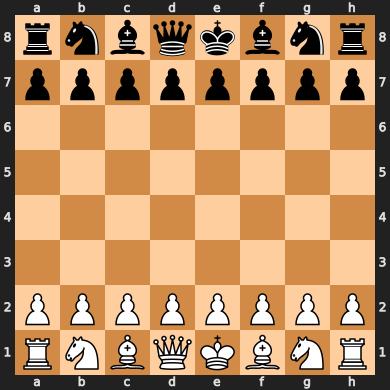

In [2]:
board = chess.Board()
board

In [3]:
def get_mapping(board, piece):
    s = str(board)
    s = re.sub(f'[^{piece}{piece.upper()} \n]', '.', str(board))
    s = re.sub(f'{piece}', '-1', s)
    s = re.sub(f'{piece.upper()}', '1', s)
    s = re.sub(f'\.', '0', s)
    
    matrix = []
    for row in s.split('\n'):
        row = row.split(' ')
        row = [int(x) for x in row]
        matrix.append(row)
    return matrix

torch.tensor(get_mapping(board, 'n'))

tensor([[ 0, -1,  0,  0,  0,  0, -1,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  0,  1,  0]])

In [4]:
def board_repr(board):
    pieces = ['p', 'r', 'n', 'b', 'q', 'k']
    layers = []
    for piece in pieces:
        layers.append(get_mapping(board, piece))
    return torch.tensor(layers)

board_repr(board).shape

torch.Size([6, 8, 8])

In [5]:
ltr_to_num = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
num_to_ltr = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}

In [6]:
def move_repr(move):
    start = [[0] * 8 for _ in range(8)]
    start_row = 8 - int(move[1])
    start_col = ltr_to_num[move[0]]
    start[start_row][start_col] = 1
    
    end = [[0] * 8 for _ in range(8)]
    end_row = 8 - int(move[3])
    end_col = ltr_to_num[move[2]]
    end[end_row][end_col] = 1
    
    return torch.tensor([start, end])

move_repr('f1c4')

tensor([[[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]]])

In [7]:
def move_gen(pred, board_fen):
    # Create a chess board object from the given FEN string
    board = chess.Board(board_fen)
    
    # Initialize variables for the starting position
    max_score = -1 * float('inf')
    from_x, from_y = 0, 0
    
    # Loop through all legal moves on the board
    for move in board.legal_moves:
        move = str(move)
        
        # Extract row and column from the move string
        row = 8 - int(move[1])
        col = ltr_to_num[move[0]]
        
        # Get the score from the prediction for the current move
        cur_score = float(pred[0, row, col])
        
        # Update the maximum score and corresponding position if the current score is higher
        if cur_score > max_score:
            max_score = cur_score
            from_x = num_to_ltr[col]
            from_y = 8 - row
    
    # Build the starting position in chess notation (e.g., 'e2')
    start = from_x + str(from_y)
    
    # Reset max_score for the destination position
    max_score = -1 * float('inf')
    to_x, to_y = 0, 0
    
    # Loop through all legal moves again
    for move in board.legal_moves:
        move = str(move)
        
        # Check if the move starts from the previously determined starting position
        if move[:2] == start:
            # Extract row and column for the destination position
            row = 8 - int(move[3])
            col = ltr_to_num[move[2]]
            
            # Get the score from the prediction for the current move
            cur_score = float(pred[1, row, col])
            
            # Update the maximum score and corresponding position if the current score is higher
            if cur_score > max_score:
                max_score = cur_score
                to_x = num_to_ltr[col]
                to_y = 8 - row
    
    # Build the ending position in chess notation (e.g., 'e4')
    end = to_x + str(to_y)
    
    # Return the concatenated string representing the move (e.g., 'e2e4')
    return start + end

# Example usage of the move_gen function with a FEN string and a move representation
move_gen(move_repr('g1f3'), 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')

'g1f3'

In [8]:
class Block(nn.Module):
    
    def __init__(self, hidden_size):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1)
        self.batch_norm = nn.BatchNorm2d(hidden_size)
    
    def forward(self, x):
        x_copy = torch.clone(x)
        x = F.selu(self.batch_norm(self.conv1(x)))
        x = F.selu(self.batch_norm(self.conv2(x)) + x_copy)
        return x
    
class ChessNet(nn.Module):
    
    def __init__(self, input_size=6, output_size=2, hidden_size=200, num_blocks=10):
        super(ChessNet, self).__init__()
        self.input = nn.Conv2d(input_size, hidden_size, kernel_size=3, stride=1, padding=1)
        self.blocks = nn.ModuleList([Block(hidden_size) for _ in range(num_blocks)])
        self.output = nn.Conv2d(hidden_size, output_size, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        x = F.selu(self.input(x))
        for block in self.blocks:
            x = block(x)
        x = self.output(x)
        return x

model = ChessNet().cuda()
model

ChessNet(
  (input): Conv2d(6, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blocks): ModuleList(
    (0-9): 10 x Block(
      (conv1): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (output): Conv2d(200, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [9]:
class ChessDataset(Dataset):
    
    def __init__(self, dataframe):
        super(ChessDataset, self).__init__()
        self.boards = dataframe['states']
        self.moves = dataframe['moves']
        self.player = dataframe['player']
    
    def __len__(self):
        return len(self.moves)
    
    def __getitem__(self, index):
        cur_board = chess.Board(self.boards[index])
        cur_player = self.player[index]
        next_move = self.moves[index]
        x = board_repr(cur_board)
        y = move_repr(next_move)
        if cur_player == 1:
            x *= -1
        x = x.type(torch.float32)
        y = y.type(torch.float32)
        return x, y

In [10]:
dataset = pd.read_csv('/kaggle/input/chess-moves/chess_moves.csv')
print(dataset.head)

<bound method NDFrame.head of                                                      states moves  player
0         rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...  d2d4       0
1         rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...  g1f3       0
2         rnbqkb1r/ppp1pppp/5n2/3p4/3P4/5N2/PPP1PPPP/RNB...  c1f4       0
3         rnbqkb1r/pp2pppp/2p2n2/3p4/3P1B2/5N2/PPP1PPPP/...  e2e3       0
4         rn1qkb1r/pp2pppp/2p2n2/3p4/3P1Bb1/4PN2/PPP2PPP...  f1e2       0
...                                                     ...   ...     ...
29051403  6k1/ppp3pp/1bp2pn1/7Q/5P2/2P3N1/Pq1B2PP/4K3 b ...  b2b1       1
29051404  6k1/ppp3pp/1bp2pn1/7Q/5P2/2P3N1/P2BK1PP/1q6 b ...  b1a2       1
29051405  6k1/ppp3pp/1bp2pn1/5P1Q/8/2P3N1/q2BK1PP/8 b - ...  a2c4       1
29051406  6k1/ppp3pp/1bp2pn1/5P1Q/2q5/2P3N1/3B2PP/3K4 b ...  g6e5       1
29051407  6k1/ppp3pp/1bp2p2/4nP2/2q4Q/2P3N1/3B2PP/3K4 b ...  c4h4       1

[29051408 rows x 3 columns]>


In [11]:
length = 100000
data = ChessDataset(dataset[: length])
train_data, test_data = random_split(data, [0.8, 0.2])
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, drop_last=True)
len(train_data), len(test_data)

(80000, 20000)

In [12]:
loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [13]:
epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = 0
    model.train()
    for x, y in tqdm(train_dataloader):
        x, y = x.cuda(), y.cuda()
        y_pred = model(x)
        loss1 = loss_fn1(y_pred[:, 0, :], y[:, 0, :])
        loss2 = loss_fn2(y_pred[:, 1, :], y[:, 1, :])
        loss = loss1 + loss2
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    
    test_loss = 0
    model.eval()
    print(f"testing....")
    with torch.inference_mode():
        for x, y in test_dataloader:
            x, y = x.cuda(), y.cuda()
            y_pred = model(x)
            loss1 = loss_fn1(y_pred[:, 0, :], y[:, 0, :])
            loss2 = loss_fn2(y_pred[:, 1, :], y[:, 1, :])
            loss = loss1 + loss2
            test_loss += loss
        test_loss /= len(test_dataloader)
        
    print(f"Loss -> [Train: {train_loss} | Test: {test_loss}]")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.20764687657356262 | Test: 0.23253963887691498]


  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.16113464534282684 | Test: 0.22082680463790894]


  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.14197202026844025 | Test: 0.2123684287071228]


  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.12637628614902496 | Test: 0.21680349111557007]


  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.11250718683004379 | Test: 0.20700348913669586]


  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.09936985373497009 | Test: 0.20910023152828217]


  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.08769012987613678 | Test: 0.21862976253032684]


  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.07545782625675201 | Test: 0.22276708483695984]


  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.0648026093840599 | Test: 0.23108109831809998]


  0%|          | 0/2500 [00:00<?, ?it/s]

testing....
Loss -> [Train: 0.05593382939696312 | Test: 0.2458994835615158]
